<h1 align=center><font size = 5>Segmenting and Clustering Neighborhoods in London 
    - Opening a New Restaurant</font></h1>


## Introduction

London is the capital and largest city of England and the United Kingdom. It is one of the world's most important global cities and it exerts a considerable impact upon the arts, commerce, education, entertainment, finance, healthcare, media, research and development, tourism and transportation. It is one of the largest financial centres in the world and in 2019, London had the second highest number of ultra high-net-worth individuals in Europe, after Paris. 

London's estimated mid-2018 municipal population was roughly 9 million, which made it the third-most populous city in Europe. It is one of the leading tourist destinations in the world and in 2015 was ranked as the most visited city in the world with over 65 million visits. According to the www.worldcitiescultureforum.com webpage, London has more than 18000 restaurants.

For these reasons, opening a new restaurant in London, i.e., deciding where to open a restaurant and which type, is a great challenge for businessmen and enterpreneurs. In this work, we aim to provide an answer to this question by using location data 
and leveraging the Foursquare data to explore and compare neighborhoods in London. We will cluster the London neighborhoods based on the similarity of the restaurants they have and in this way, we will be able to suggest neighborhoods that would be suitable of opening restaurants based on their type.


#### Target audience
Investors, entrepreneurs, and businessmen that want to open a new restaurant in London. This work will give advice on where a new restaurant would be more successful based on its type.




## Data
In this section, we describe the data that we will use in this work. 

Firstly, we will use information about the neighborhoods of London. Specifically, the data consist of the name of the neighborhood, the borough of London where the neigborhood is located, and its postcode. We get the neighborhoods' data from Wikipedia 'https://en.wikipedia.org/wiki/List_of_areas_of_London'. Below, we give a snapshot of the collected Wikipedia data, after some steps of data cleaning and preparation. 
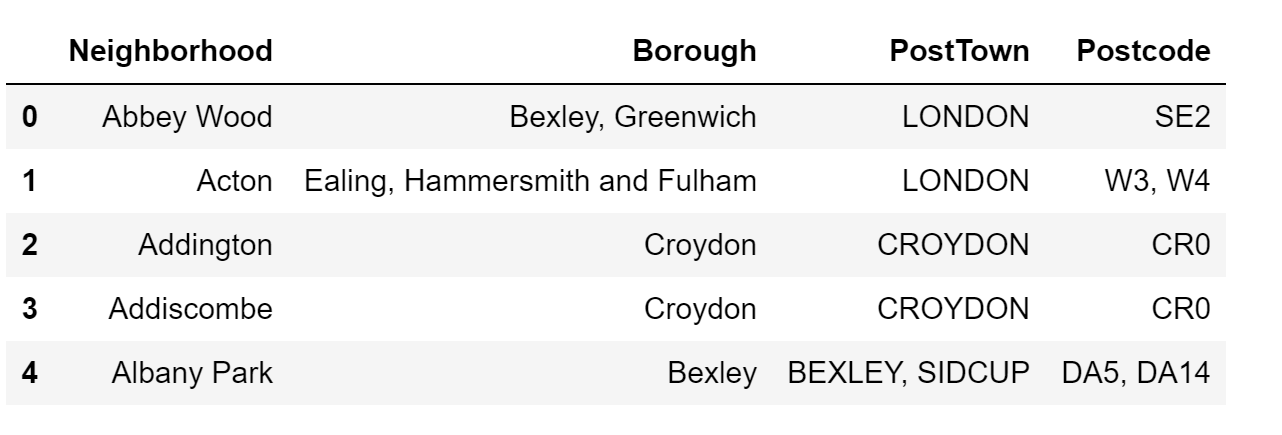

Furthermore, we will need the latitude and longitude of each neighborhood. To obtain this information, we use the library geopy. Below, we give a snapshot of the London neighborhoods' data, including the latitude and longitude of each neighborhood. 
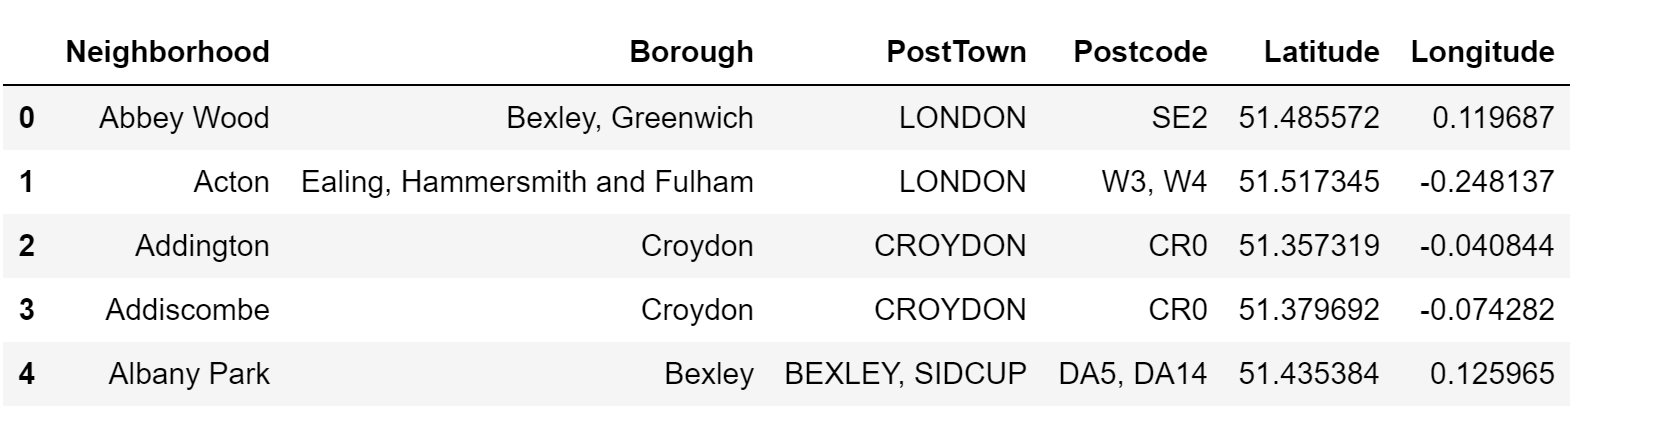


Finally, we use the Foursquare data to get information about the top 100 restaurants within 500m radius from each neighborhood. Below, we give a snapshot of the five most frequent types of restaurants in each London neighborhood.
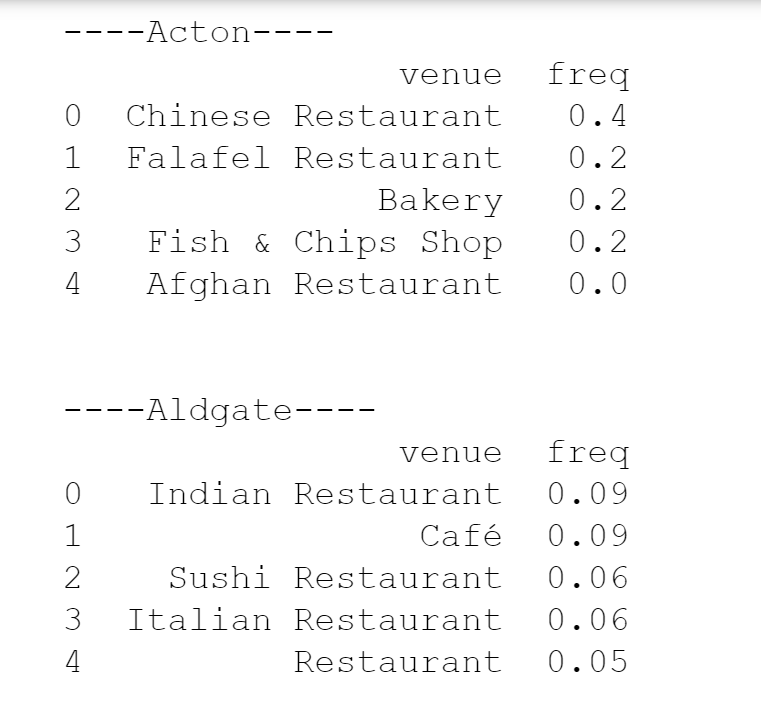

## Methodology

Before we get the data and start exploring it, let's download all the dependencies that we will need.


In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
#import folium # map rendering library

print('Libraries imported.')

Libraries imported.


In [2]:
!pip install folium==0.5.0 
import folium

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
     |████████████████████████████████| 79 kB 6.0 MB/s  eta 0:00:01
  Created wheel for folium: filename=folium-0.5.0-py3-none-any.whl size=76240 sha256=04d402d74d5b483d5206ac92481162d5dab06196c6c45a2eef2a657ebca05c17
  Stored in directory: /tmp/wsuser/.cache/pip/wheels/b2/2f/2c/109e446b990d663ea5ce9b078b5e7c1a9c45cca91f377080f8
Successfully built folium


In [3]:
import lxml

<a id='item1'></a>


### 1. Download and Explore Dataset


We firstly read the Wikipedia table with information about the neighborhoods of London.

In [4]:
url='https://en.wikipedia.org/wiki/List_of_areas_of_London'
df = pd.read_html(url, header=0)
df=df[1]

In [5]:
df.head()

,Location,London borough,Post town,Postcode district,Dial code,OS grid ref
0,Abbey Wood,"Bexley, Greenwich [7]",LONDON,SE2,020,TQ465785
1,Acton,"Ealing, Hammersmith and Fulham[8]",LONDON,"W3, W4",020,TQ205805
2,Addington,Croydon[8],CROYDON,CR0,020,TQ375645
3,Addiscombe,Croydon[8],CROYDON,CR0,020,TQ345665
4,Albany Park,Bexley,"BEXLEY, SIDCUP","DA5, DA14",020,TQ478728


We rename the columns, so that that they will be more convenient to use, and we select the columns that are going to be used in this work 


In [6]:
df.columns=['Neighborhood','Borough','PostTown','Postcode','Dialcode','OS']
df=df[['Neighborhood','Borough','PostTown','Postcode']]

In [7]:
df.head()

,Neighborhood,Borough,PostTown,Postcode
0,Abbey Wood,"Bexley, Greenwich [7]",LONDON,SE2
1,Acton,"Ealing, Hammersmith and Fulham[8]",LONDON,"W3, W4"
2,Addington,Croydon[8],CROYDON,CR0
3,Addiscombe,Croydon[8],CROYDON,CR0
4,Albany Park,Bexley,"BEXLEY, SIDCUP","DA5, DA14"


We notice that the Borough column requires some cleaning so that it only includes the name of the Borough.


In [8]:
df['Borough']=df['Borough'].map(lambda x: x.rstrip(']').rstrip('0123456789').rstrip('['))
df['Borough'].head()

0                Bexley, Greenwich 
1    Ealing, Hammersmith and Fulham
2                           Croydon
3                           Croydon
4                            Bexley
Name: Borough, dtype: object

In [9]:
df.head()

,Neighborhood,Borough,PostTown,Postcode
0,Abbey Wood,"Bexley, Greenwich",LONDON,SE2
1,Acton,"Ealing, Hammersmith and Fulham",LONDON,"W3, W4"
2,Addington,Croydon,CROYDON,CR0
3,Addiscombe,Croydon,CROYDON,CR0
4,Albany Park,Bexley,"BEXLEY, SIDCUP","DA5, DA14"


In [10]:
df.shape

(531, 4)

As there is a large number of neighborhoods and there is only a limited number of Foursquare API calls, we keep only the neighborhoods with PostTown equal to London.  

In [11]:
df=df.loc[df['PostTown'] == 'LONDON']

In [12]:
df.shape[0]

297

We insert and initialize two columns, Latitude and Longitude, where the corresponding information of each neighborhood is going to be saved.

In [13]:
df.insert(2,'Latitude',[0]*(df.shape[0]),True)


In [14]:
df.insert(2,'Longitude',[0]*(df.shape[0]),True)

In [15]:
df=df[['Neighborhood','Borough','PostTown','Postcode','Latitude','Longitude']]
df.head()

,Neighborhood,Borough,PostTown,Postcode,Latitude,Longitude
0,Abbey Wood,"Bexley, Greenwich",LONDON,SE2,0,0
1,Acton,"Ealing, Hammersmith and Fulham",LONDON,"W3, W4",0,0
6,Aldgate,City,LONDON,EC3,0,0
7,Aldwych,Westminster,LONDON,WC2,0,0
9,Anerley,Bromley,LONDON,SE20,0,0


The following loop over the Dataframe gets the Latitude and Longitude of each neighborhood, using the library geopy.

In [16]:
import time
for i in range(len(df)):
    time.sleep(2.5)
    address = ', '.join(list(df.iloc[i, :3]))
    geolocator = Nominatim(user_agent='london_user')
    location = geolocator.geocode(address)
    if location == None:
        continue
    latitude = location.latitude
    longitude = location.longitude
    df.iloc[i,4] = latitude
    df.iloc[i,5] = longitude

In [17]:
df.head()

,Neighborhood,Borough,PostTown,Postcode,Latitude,Longitude
0,Abbey Wood,"Bexley, Greenwich",LONDON,SE2,51.485572,0.119687
1,Acton,"Ealing, Hammersmith and Fulham",LONDON,"W3, W4",51.517345,-0.248137
6,Aldgate,City,LONDON,EC3,51.514248,-0.075719
7,Aldwych,Westminster,LONDON,WC2,51.512200,-0.118896
9,Anerley,Bromley,LONDON,SE20,51.407599,-0.061939


In [18]:
df.shape

(297, 6)

We remove the neighborhoods that have Latitude=0 or Longitude=0, i.e., the neighborhoods for which we were not able to get their Latitude or Longitude using geopy.

In [19]:
df=df.loc[df['Latitude'] != 0]

In [20]:
df=df.loc[df['Longitude'] != 0]

In [21]:
df.shape

(289, 6)

We quickly examine the resulting dataframe.


In [22]:
df.reset_index(drop=True, inplace=True)
df.head()

,Neighborhood,Borough,PostTown,Postcode,Latitude,Longitude
0,Abbey Wood,"Bexley, Greenwich",LONDON,SE2,51.485572,0.119687
1,Acton,"Ealing, Hammersmith and Fulham",LONDON,"W3, W4",51.517345,-0.248137
2,Aldgate,City,LONDON,EC3,51.514248,-0.075719
3,Aldwych,Westminster,LONDON,WC2,51.512200,-0.118896
4,Anerley,Bromley,LONDON,SE20,51.407599,-0.061939


In [23]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(df['Borough'].unique()),
        df.shape[0]
    )
)

The dataframe has 43 boroughs and 289 neighborhoods.


We use geopy library to get the latitude and longitude values of London.


In [24]:
address = 'London'

geolocator = Nominatim(user_agent="london_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of London are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of London are 51.5073219, -0.1276474.


#### Create a map of London with neighborhoods superimposed on top.


In [25]:
# create map of London using latitude and longitude values
map_london = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_london)  
    
map_london


## 2. Foursquare Data
Next, we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them.


Define Foursquare Credentials and Version


In [56]:
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value
CLIENT_ID = ##### #add here client_id
CLIENT_SECRET = ##### #add here client_secret

The following function will be used to get the top restaurants in each neighborhood.


In [27]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&query=restaurant'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)


Now, let's get the top 100 restaurants that are in each neighborhood within a radius of 500 meters, using the above function.


In [28]:
london_venues = getNearbyVenues(names=df['Neighborhood'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )


Abbey Wood
Acton
Aldgate
Aldwych
Anerley
Angel
Archway
Arnos Grove
Balham
Bankside
Barbican
Barnes
Barnsbury
Battersea
Bayswater
Bedford Park
Belgravia
Bellingham
Belsize Park
Bermondsey
Bethnal Green
Blackfriars
Blackheath
Blackheath Royal Standard
Blackwall
Bloomsbury
Bounds Green
Bow
Bowes Park
Brent Cross
Brent Park
Brixton
Brockley
Brompton
Brondesbury
Brunswick Park
Burroughs, The
Camberwell
Cambridge Heath
Camden Town
Canary Wharf
Cann Hall
Canning Town
Canonbury
Castelnau
Catford
Chalk Farm
Charing Cross
Charlton
Chelsea
Childs Hill
Chinatown
Chinbrook
Chingford
Church End
Church End
Clapham
Clerkenwell
Colindale
Colliers Wood
Colney Hatch
Covent Garden
Cricklewood
Crofton Park
Crossness
Crouch End
Crystal Palace
Cubitt Town
Custom House
Dalston
Denmark Hill
Deptford
Dollis Hill
Dulwich
Ealing
Earls Court
Earlsfield
East Dulwich
East Finchley
East Ham
East Sheen
Edmonton
Elephant and Castle
Eltham
Farringdon
Finchley
Finsbury
Finsbury Park
Fitzrovia
Forest Gate
Forest Hill
Fort

Let's check how many venues were returned for each neighborhood


In [29]:
london_venues.groupby('Neighborhood').count().head()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Abbey Wood,1,1,1,1,1,1
Acton,5,5,5,5,5,5
Aldgate,100,100,100,100,100,100
Aldwych,59,59,59,59,59,59
Anerley,5,5,5,5,5,5


<a id='item2'></a>


In [30]:
print('There are {} uniques categories.'.format(len(london_venues['Venue Category'].unique())))

There are 122 uniques categories.


In [31]:
london_venues['Venue Category'].unique()

array(['Café', 'Falafel Restaurant', 'Bakery', 'Fish & Chips Shop',
       'Chinese Restaurant', 'Food Truck', 'Vietnamese Restaurant',
       'Pizza Place', 'Italian Restaurant', 'Japanese Restaurant',
       'Indian Restaurant', 'Restaurant', 'Argentinian Restaurant',
       'English Restaurant', 'Salad Place', 'Szechuan Restaurant',
       'Steakhouse', 'Sushi Restaurant', 'BBQ Joint', 'Burger Joint',
       'Asian Restaurant', 'Middle Eastern Restaurant',
       'Korean Restaurant', 'Mediterranean Restaurant',
       'Cantonese Restaurant', 'Gastropub', 'French Restaurant',
       'Thai Restaurant', 'Greek Restaurant', 'Empanada Restaurant',
       'Vegetarian / Vegan Restaurant', 'Fast Food Restaurant',
       'American Restaurant', 'Turkish Restaurant', 'Mexican Restaurant',
       'Modern European Restaurant', 'Malay Restaurant',
       'Moroccan Restaurant', 'Poke Place', 'Seafood Restaurant',
       'Sandwich Place', 'Portuguese Restaurant', 'Brasserie',
       'Lebanese Resta

## 3. Analyze Each Neighborhood


In [32]:
# one hot encoding
london_onehot = pd.get_dummies(london_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
london_onehot['Neighborhood'] = london_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [london_onehot.columns[-1]] + list(london_onehot.columns[:-1])
london_onehot = london_onehot[fixed_columns]

london_onehot.head()

,Neighborhood,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bistro,Brasserie,Brazilian Restaurant,Breakfast Spot,Burger Joint,Burrito Place,Cafeteria,Café,Cajun / Creole Restaurant,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Chinese Restaurant,Churrascaria,Cigkofte Place,Creperie,Cuban Restaurant,Czech Restaurant,Deli / Bodega,Dim Sum Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Food,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Gastropub,German Restaurant,Gluten-free Restaurant,Greek Restaurant,Halal Restaurant,Hawaiian Restaurant,Himalayan Restaurant,Hot Dog Joint,Hunan Restaurant,Hungarian Restaurant,Indian Restaurant,Indonesian Restaurant,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jewish Restaurant,Kebab Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Lebanese Restaurant,Malay Restaurant,Mamak Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,Moroccan Restaurant,New American Restaurant,Noodle House,North Indian Restaurant,Okonomiyaki Restaurant,Pakistani Restaurant,Persian Restaurant,Peruvian Restaurant,Pizza Place,Poke Place,Polish Restaurant,Portuguese Restaurant,Ramen Restaurant,Restaurant,Russian Restaurant,Salad Place,Sandwich Place,Scandinavian Restaurant,Seafood Restaurant,Shabu-Shabu Restaurant,Snack Place,Soup Place,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Souvlaki Shop,Spanish Restaurant,Sri Lankan Restaurant,Steakhouse,Sushi Restaurant,Syrian Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Veneto Restaurant,Vietnamese Restaurant,Wings Joint,Xinjiang Restaurant
0,Abbey Wood,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Acton,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Acton,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Acton,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Acton,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


And let's examine the new dataframe size.


In [33]:
london_onehot.shape

(5941, 123)

 Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category.


In [34]:
london_grouped = london_onehot.groupby('Neighborhood').mean().reset_index()
london_grouped.head()

,Neighborhood,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bistro,Brasserie,Brazilian Restaurant,Breakfast Spot,Burger Joint,Burrito Place,Cafeteria,Café,Cajun / Creole Restaurant,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Chinese Restaurant,Churrascaria,Cigkofte Place,Creperie,Cuban Restaurant,Czech Restaurant,Deli / Bodega,Dim Sum Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Food,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Gastropub,German Restaurant,Gluten-free Restaurant,Greek Restaurant,Halal Restaurant,Hawaiian Restaurant,Himalayan Restaurant,Hot Dog Joint,Hunan Restaurant,Hungarian Restaurant,Indian Restaurant,Indonesian Restaurant,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jewish Restaurant,Kebab Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Lebanese Restaurant,Malay Restaurant,Mamak Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,Moroccan Restaurant,New American Restaurant,Noodle House,North Indian Restaurant,Okonomiyaki Restaurant,Pakistani Restaurant,Persian Restaurant,Peruvian Restaurant,Pizza Place,Poke Place,Polish Restaurant,Portuguese Restaurant,Ramen Restaurant,Restaurant,Russian Restaurant,Salad Place,Sandwich Place,Scandinavian Restaurant,Seafood Restaurant,Shabu-Shabu Restaurant,Snack Place,Soup Place,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Souvlaki Shop,Spanish Restaurant,Sri Lankan Restaurant,Steakhouse,Sushi Restaurant,Syrian Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Veneto Restaurant,Vietnamese Restaurant,Wings Joint,Xinjiang Restaurant
0,Abbey Wood,0.0,0.0,0.000000,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,1.000000,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.00,0.0,0.00,0.000000,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00,0.0,0.000000,0.000000,0.000000,0.0,0.00,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.00,0.0,0.0,0.000000,0.000000,0.00,0.0,0.00,0.0,0.000000,0.0,0.0
1,Acton,0.0,0.0,0.000000,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.200000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.00,0.0,0.0,0.40,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.20,0.000000,0.0,0.2,0.0,0.0,0.0,0.00,0.000000,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.00,0.0,0.00,0.000000,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00,0.0,0.000000,0.000000,0.000000,0.0,0.00,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.00,0.0,0.0,0.000000,0.000000,0.00,0.0,0.00,0.0,0.000000,0.0,0.0
2,Aldgate,0.0,0.0,0.010000,0.0,0.01,0.02,0.0,0.0,0.02,0.0,0.010000,0.0,0.000000,0.0,0.0,0.010000,0.000000,0.0,0.090000,0.0,0.01,0.0,0.0,0.01,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.020000,0.0,0.01,0.010000,0.0,0.0,0.0,0.0,0.0,0.02,0.010000,0.0,0.01,0.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,0.0,0.090000,0.0,0.0,0.0,0.060000,0.0,0.040000,0.0,0.0,0.020000,0.0,0.0,0.000000,0.01,0.0,0.02,0.010000,0.04,0.01,0.0,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.040000,0.01,0.0,0.010000,

Let's confirm the new size.


In [35]:
london_grouped.shape

(283, 123)

Let's print each neighborhood along with the top 5 most common venues.


In [36]:
num_top_venues = 5

for hood in london_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = london_grouped[london_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Abbey Wood----
                             venue  freq
0                             Café   1.0
1                Afghan Restaurant   0.0
2  Molecular Gastronomy Restaurant   0.0
3            Portuguese Restaurant   0.0
4                Polish Restaurant   0.0


----Acton----
                venue  freq
0  Chinese Restaurant   0.4
1  Falafel Restaurant   0.2
2              Bakery   0.2
3   Fish & Chips Shop   0.2
4   Afghan Restaurant   0.0


----Aldgate----
                venue  freq
0   Indian Restaurant  0.09
1                Café  0.09
2  Italian Restaurant  0.06
3    Sushi Restaurant  0.06
4     Thai Restaurant  0.05


----Aldwych----
                venue  freq
0          Restaurant  0.12
1      Sandwich Place  0.10
2              Bakery  0.07
3                Café  0.07
4  English Restaurant  0.05


----Anerley----
                  venue  freq
0                  Café   0.6
1  Fast Food Restaurant   0.2
2     Fish & Chips Shop   0.2
3     Afghan Restaurant   0.0
4   Morocca

The following function sorts the venues in descending order.


In [37]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.


In [38]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = london_grouped['Neighborhood']

for ind in np.arange(london_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(london_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Abbey Wood,Café,Xinjiang Restaurant,Food Court,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant
1,Acton,Chinese Restaurant,Falafel Restaurant,Bakery,Fish & Chips Shop,Xinjiang Restaurant,Food Stand,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant
2,Aldgate,Café,Indian Restaurant,Italian Restaurant,Sushi Restaurant,Thai Restaurant,Restaurant,Middle Eastern Restaurant,Japanese Restaurant,Pizza Place,Salad Place
3,Aldwych,Restaurant,Sandwich Place,Café,Bakery,English Restaurant,Italian Restaurant,Burger Joint,Sushi Restaurant,Korean Restaurant,Japanese Restaurant
4,Anerley,Café,Fast Food Restaurant,Fish & Chips Shop,Xinjiang Restaurant,Food Court,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant


<a id='item4'></a>


In [39]:
neighborhoods_venues_sorted.shape

(283, 11)

## 4. Cluster Neighborhoods


We will run _k_-means to cluster the London neighborhoods. We will use the elbow method to find the optimal number of clusters.


In [40]:
!pip install yellowbrick

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
     |████████████████████████████████| 271 kB 14.2 MB/s eta 0:00:01


In [41]:
from yellowbrick.cluster import KElbowVisualizer

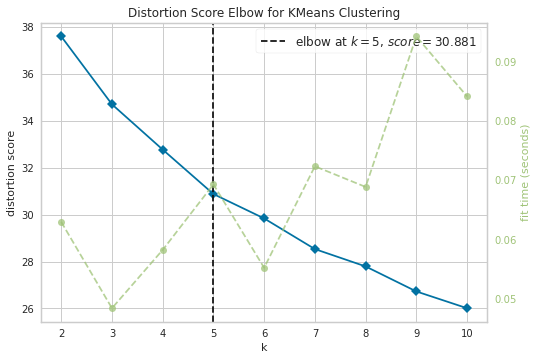

In [43]:
london_clustering=london_grouped.drop('Neighborhood', 1)
model=KMeans()
visualizer=KElbowVisualizer(model,k=(2,11))
visualizer.fit(london_clustering)
visualizer.poof()

We observe that by the Elbow method the optimal k is equal to 5. We run kMeans with k=5.

In [44]:
# set number of clusters
kclusters = 5

london_grouped_clustering = london_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(london_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([4, 2, 2, 2, 4, 2, 1, 1, 2, 2], dtype=int32)

We create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.


In [48]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels',kmeans.labels_)

london_merged = df
london_merged = london_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'),how='right', on='Neighborhood')
london_merged.head()

,Neighborhood,Borough,PostTown,Postcode,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Abbey Wood,"Bexley, Greenwich",LONDON,SE2,51.485572,0.119687,4,Café,Xinjiang Restaurant,Food Court,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant
1,Acton,"Ealing, Hammersmith and Fulham",LONDON,"W3, W4",51.517345,-0.248137,2,Chinese Restaurant,Falafel Restaurant,Bakery,Fish & Chips Shop,Xinjiang Restaurant,Food Stand,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant
2,Aldgate,City,LONDON,EC3,51.514248,-0.075719,2,Café,Indian Restaurant,Italian Restaurant,Sushi Restaurant,Thai Restaurant,Restaurant,Middle Eastern Restaurant,Japanese Restaurant,Pizza Place,Salad Place
3,Aldwych,Westminster,LONDON,WC2,51.512200,-0.118896,2,Restaurant,Sandwich Place,Café,Bakery,English Restaurant,Italian Restaurant,Burger Joint,Sushi Restaurant,Korean Restaurant,Japanese Restaurant
4,Anerley,Bromley,LONDON,SE20,51.407599,-0.061939,4,Café,Fast Food Restaurant,Fish & Chips Shop,Xinjiang Restaurant,Food Court,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant


Finally, let's visualize the resulting clusters.


In [49]:
london_merged.shape

(285, 17)

In [50]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(london_merged['Latitude'],london_merged['Longitude'], london_merged['Neighborhood'], london_merged['Cluster Labels']):
        label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup=label,
            color=rainbow[cluster-1],
            fill=True,
            fill_color=rainbow[cluster-1],
            fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

<a id='item5'></a>


## Results 


Now, we can examine each cluster and determine the discriminating venue categories that distinguish each cluster.

#### Cluster 1
We observe that in Cluster 1, neighborhoods contain many Indian Restaurants.


In [51]:
london_merged.loc[london_merged['Cluster Labels'] == 0, london_merged.columns[[0] + list(range(6, london_merged.shape[1]))]]


,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
17,Bellingham,0,Indian Restaurant,Vegetarian / Vegan Restaurant,Café,Xinjiang Restaurant,Food,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant
67,Cubitt Town,0,Indian Restaurant,Café,Food Truck,Food Court,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant
79,East Ham,0,Indian Restaurant,Fast Food Restaurant,Sandwich Place,Bakery,Xinjiang Restaurant,Food,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant
99,Grange Park,0,Indian Restaurant,English Restaurant,Diner,Hunan Restaurant,Food,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant
157,Manor Park,0,Indian Restaurant,Restaurant,Turkish Restaurant,Asian Restaurant,Xinjiang Restaurant,English Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant
158,Maryland,0,Indian Restaurant,Thai Restaurant,English Restaurant,Eastern European Restaurant,Pizza Place,Hungarian Restaurant,Café,Portuguese Restaurant,Australian Restaurant,Food Stand
166,Millwall,0,Indian Restaurant,Middle Eastern Restaurant,Chinese Restaurant,Korean Restaurant,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant
248,Totteridge,0,Indian Restaurant,Dim Sum Restaurant,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant
257,Upton Park,0,Indian Restaurant,Sandwich Place,Bakery,Fast Food Restaurant,Xinjiang Restaurant,Food,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant
272,West Heath,0,Indian Restaurant,Dim Sum Restaurant,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant


#### Cluster 2

We observe that in Cluster 2, neighborhoods contain many Italian Restaurants, pizza places and coffee places.

In [52]:
london_merged.loc[london_merged['Cluster Labels'] == 1, london_merged.columns[[0] + list(range(6, london_merged.shape[1]))]]


,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,Archway,1,Café,Pizza Place,Fast Food Restaurant,Sandwich Place,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Vegetarian / Vegan Restaurant,Food Court,Asian Restaurant
7,Arnos Grove,1,Indian Restaurant,Chinese Restaurant,Café,Fish & Chips Shop,Food Court,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant
11,Barnes,1,Breakfast Spot,Pizza Place,Café,Restaurant,Thai Restaurant,Bakery,Ethiopian Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant
12,Barnsbury,1,Café,Ethiopian Restaurant,Gastropub,Chinese Restaurant,Bakery,Italian Restaurant,Caucasian Restaurant,Middle Eastern Restaurant,Food,Fish & Chips Shop
15,Bedford Park,1,Café,Mediterranean Restaurant,Bakery,French Restaurant,Middle Eastern Restaurant,Pizza Place,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Food
16,Belgravia,1,Café,Restaurant,French Restaurant,Italian Restaurant,Gastropub,Pakistani Restaurant,Seafood Restaurant,English Restaurant,Spanish Restaurant,Sushi Restaurant
18,Belsize Park,1,Café,Bakery,Indian Restaurant,Italian Restaurant,Deli / Bodega,Pizza Place,Lebanese Restaurant,Tapas Restaurant,Greek Restaurant,Bagel Shop
19,Bermondsey,1,Café,Indonesian Restaurant,Bakery,Chinese Restaurant,Fish & Chips Shop,Pizza Place,Brazilian Restaurant,Fried Chicken Joint,Burger Joint,Asian Restaurant
20,Bethnal Green,1,Café,Pizza Place,Fast Food Restaurant,Breakfast Spot,Vegetarian / Vegan Restaurant,Italian Restaurant,Sandwich Place,Falafel Restaurant,Restaurant,Korean Restaurant
23,Blackheath Royal Standard,1,Café,Deli / Bodega,Chinese Restaurant,Fast Food Restaurant,Bakery,Food Court,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant


#### Cluster 3
We observe that neighborhoods in Cluster 3 have many coffee places, breakfast spots and bakeries.

In [53]:
london_merged.loc[london_merged['Cluster Labels'] == 2, london_merged.columns[[0] + list(range(6, london_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Acton,2,Chinese Restaurant,Falafel Restaurant,Bakery,Fish & Chips Shop,Xinjiang Restaurant,Food Stand,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant
2,Aldgate,2,Café,Indian Restaurant,Italian Restaurant,Sushi Restaurant,Thai Restaurant,Restaurant,Middle Eastern Restaurant,Japanese Restaurant,Pizza Place,Salad Place
3,Aldwych,2,Restaurant,Sandwich Place,Café,Bakery,English Restaurant,Italian Restaurant,Burger Joint,Sushi Restaurant,Korean Restaurant,Japanese Restaurant
5,Angel,2,Café,Sushi Restaurant,Restaurant,Italian Restaurant,Sandwich Place,Burrito Place,Vegetarian / Vegan Restaurant,Pizza Place,Burger Joint,Indian Restaurant
8,Balham,2,Café,Indian Restaurant,Pizza Place,Bakery,Fast Food Restaurant,Fish & Chips Shop,Breakfast Spot,Sandwich Place,Burger Joint,Italian Restaurant
9,Bankside,2,Italian Restaurant,Café,Ramen Restaurant,Spanish Restaurant,Bistro,Restaurant,Bakery,Portuguese Restaurant,English Restaurant,Food
10,Barbican,2,Italian Restaurant,Café,French Restaurant,Sandwich Place,Sushi Restaurant,Vietnamese Restaurant,Food Truck,English Restaurant,South American Restaurant,Soup Place
13,Battersea,2,Bakery,Café,Pizza Place,Chinese Restaurant,Japanese Restaurant,Mexican Restaurant,Sandwich Place,Food Truck,Creperie,Bistro
14,Bayswater,2,Café,Italian Restaurant,Chinese Restaurant,Restaurant,Indian Restaurant,Pizza Place,Malay Restaurant,Persian Restaurant,Sandwich Place,Greek Restaurant
21,Blackfriars,2,Italian Restaurant,Sandwich Place,Vietnamese Restaurant,Café,Burger Joint,Sushi Restaurant,English Restaurant,Falafel Restaurant,Restaurant,Bakery


#### Cluster 4


In [54]:
london_merged.loc[london_merged['Cluster Labels'] == 3, london_merged.columns[[0] + list(range(6, london_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
30,Brent Park,3,Asian Restaurant,Xinjiang Restaurant,Food Stand,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant
129,The Hyde,3,Asian Restaurant,Xinjiang Restaurant,Food Stand,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant


#### Cluster 5
We observe that neighborhoods in Cluster 5 contain many coffee places and Xinjiang restaurants.


In [55]:
london_merged.loc[london_merged['Cluster Labels'] == 4,london_merged.columns[[1] + list(range(6, london_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Bexley, Greenwich",4,Café,Xinjiang Restaurant,Food Court,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant
4,Bromley,4,Café,Fast Food Restaurant,Fish & Chips Shop,Xinjiang Restaurant,Food Court,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant
125,Hackney,4,Café,Pizza Place,Fish & Chips Shop,Xinjiang Restaurant,Food,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant
152,Newham,4,Café,Xinjiang Restaurant,Food Court,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant
169,Brent,4,Café,Portuguese Restaurant,Xinjiang Restaurant,Food,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant
181,Barnet,4,Café,Fried Chicken Joint,Xinjiang Restaurant,Food Court,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant
182,Tower Hamlets,4,Café,Fish & Chips Shop,Bakery,Turkish Restaurant,Fast Food Restaurant,Xinjiang Restaurant,Ethiopian Restaurant,Filipino Restaurant,Falafel Restaurant,English Restaurant
203,Southwark,4,Café,Vietnamese Restaurant,Xinjiang Restaurant,Food Court,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant
210,Greenwich,4,Café,Xinjiang Restaurant,Food Court,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant
286,Barnet,4,Café,Xinjiang Restaurant,Food Court,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant


## Discussion

Based on our results, i.e. how frequent are different types of restaurants in each cluster, we make the following recommendations:
1. Cluster 1 is not a good option for opening an Indian restaurant. Clusters 2, 4 and 5 are better options as Indian restaurants are less frequent.
2. Cluster 1 is a good option for opening a Xinjiang restaurant whereas Clusters 4 and 5 are the worst options for opening a Xinjiang restaurant.
3. Cluster 3 is not a good option for opening a coffee place or bakery. Clusters 1 and 4 are better options. 
4. Clusters 2 and 3 are not good options for opening a pizza place. Clusters 1 and 5 are better options.
5. Cluster 2 is a bad option for opening an Italian restaurant whereas Cluster 4 and 5 are the best options.


## Conclusions

In this work, we clustered the neighborhoods of London based on the different types of restaurants they contain. Using these results, we concluded in which clusters it is recommended to open different type of restaurants, recommending the clusters where each given type is not very frequent. As our recommendations are based only on the frequency of the different types, it would be interesting as future work to use other types of data as well such as the demographic data and average land prices for London neighborhoods.